# Estruturação das redes

In [6]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pyAgrum as gum
import pyAgrum.lib.explain as explain
from sklearn.dummy import DummyClassifier
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bnvsbn
import pyAgrum.lib.image as gimg
import graphviz

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo',
                        'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']].loc[~df['cid10_faixa'].isnull()]
diagnosticos = diagnosticos.fillna('Sem')

In [8]:
df_train, df_test = train_test_split(diagnosticos, train_size = 0.8, random_state=42)

In [9]:
# Faltou a variável "doenca_infecto"
template = gum.BayesNet('Plus')
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes']
for i in labels:
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
template

(pyAgrum.BayesNet<double>@0x55c6b950de20) BN{nodes: 14, arcs: 0, domainSize: 10^9.85975, dim: 79, mem: 744o}

In [10]:
print(template)

BN{nodes: 14, arcs: 0, domainSize: 10^9.85975, dim: 79, mem: 744o}


In [11]:
gimg.export(template,"template.pdf")

## Naive Bayes sem dados de treino

In [12]:
labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

alta = ''
for j in diagnosticos['cid10_faixa_alta'].unique():
  alta += '|' + str(j)
alta = 'cid10_faixa_alta{' + alta[1:] + '}'

conections = ''
for i in labels2:
  label = ''
  for j in diagnosticos[i].unique():
    label += '|' + str(j)
  label = i + '{' + label[1:] + '}'

  conections += f'{label}<-{alta};'
bn=gum.fastBN(conections)
gnb.showBN(bn)

In [13]:
gimg.export(bn,"bn.pdf")

In [14]:
conections

'cid10_faixa{F10-F19|F60-F69|F30-F39|F70-F79|F20-F29|F01-F09|F40-F49|F90-F98|F99-F99|F50-F59|F80-F89}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};cid10_seg_faixa{Sem|F60-F69|F10-F19|F30-F39|F20-F29|F01-F09|F70-F79|F40-F49|F50-F59|F90-F98|F80-F89|F99-F99}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};sexo{F|M|T}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};faixa_etaria{40-49|30-39|60-69|15-19|20-29|50-59|NAN|10-14|70-79|0-9|>80}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};etnia{BRANCO|PARDO|NEGRO|NAO INFORMADO|AMARELO}<-cid10_faixa_alta{F10-F19|F60-F69|F30-F39|F01-F09|F20-F29|F70-F79|Sem|F90-F98|F40-F49|F99-F99|F50-F59|F80-F89};qtd_internacoes{8|4|2|3|5|12|13|1|6|15|7|10|18|14|9|20|16|17|11}<-cid10_faixa_alta{F10-F19|F60-F69|F

## Naive Bayes com dados de treino

In [15]:
learner = gum.BNLearner(df_train, bn)
bn1 = learner.learnParameters(bn.dag())
bn1

(pyAgrum.BayesNet<double>@0x55c6b97bbb20) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 827, mem: 7Ko 704o}

In [16]:
gimg.export(bn1,"bn1.pdf")

## Naive Bayes Fixado

In [17]:
learner = gum.BNLearner(df_train, bn)

for i in labels2:
  learner.addMandatoryArc(i, 'cid10_faixa_alta')
bn2 = learner.learnParameters(bn.dag())
bn2

(pyAgrum.BayesNet<double>@0x55c6b98ec0f0) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 827, mem: 7Ko 704o}

In [18]:
gimg.export(bn2,"bn2.pdf")

## Rede encontrada a partir dos dados de treino

In [19]:
learner = gum.BNLearner(df_train, template)
bn3 = learner.learnBN()
bn3

(pyAgrum.BayesNet<double>@0x55c6b9797fc0) BN{nodes: 14, arcs: 12, domainSize: 10^9.85975, dim: 377, mem: 3Ko 608o}

In [20]:
gimg.export(bn3,"bn3.pdf")

## Rede encontrada a partir dos dados de treino, com conexões obrigatórias

In [21]:
learner = gum.BNLearner(df_train, template)
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
learner.addMandatoryArc('cid10_faixa', 'cid10_faixa_alta')

bn4 = learner.learnBN()
bn4

(pyAgrum.BayesNet<double>@0x55c6b994a900) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 4590, mem: 39Ko 376o}

In [22]:
gimg.export(bn4,"bn4.pdf")

## Rede encontrada utilizando a estrutura do naive bayes não fixada



In [23]:
learner = gum.BNLearner(df_train, bn)
bn5 = learner.learnBN()
bn5

(pyAgrum.BayesNet<double>@0x55c6b99fa200) BN{nodes: 14, arcs: 12, domainSize: 10^9.85975, dim: 377, mem: 3Ko 608o}

In [24]:
gimg.export(bn5,"bn5.pdf")

# Classificador

In [25]:
import pyAgrum.skbn as skbn

In [26]:
y_train = df_train['cid10_faixa_alta']
X_train = df_train.drop(['cid10_faixa_alta'], axis=1)
y_test = df_test['cid10_faixa_alta']
X_test = df_test.drop(['cid10_faixa_alta'], axis=1)

In [27]:
scoreAll = pd.DataFrame()

## Naive Bayes sem dados de treino

In [28]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes sem treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F20-F29', 'F01-F09', 'F01-F09', 'F01-F09', 'F20-F29', 'F40-F49', 'F90-F98', 'F20-F29', 'F30-F39', 'F90-F98', 'F20-F29', 'F99-F99', 'F01-F09', 'F30-F39', 'Sem', 'F30-F39', 'F40-F49', 'F40-F49', 'F20-F29', 'F20-F29', 'F40-F49', 'F01-F09', 'F20-F29', 'F01-F09', 'F20-F29', 'F40-F49', 'F60-F69', 'F20-F29', 'F20-F29', 'F40-F49', 'F40-F49', 'F01-F09', 'F20-F29', 'F20-F29', 'Sem', 'F99-F99', 'F90-F98', 'F30-F39', 'F30-F39', 'F01-F09', 'F01-F09', 'F40-F49', 'F30-F39', 'F20-F29', 'F01-F09', 'Sem', 'F20-F29', 'F20-F29', 'F01-F09', 'F20-F29', 'F40-F49', 'F20-F29', 'F99-F99', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F40-F49', 'F20-F29', 'F40-F49', 'F20-F29', 'F01-F09', 'F01-F09', 'F01-F09', 'F20-F29', 'F01-F09', 'F30-F39', 'Sem', 'F99-F99', 'Sem', 'F01-F09', 'F30-F39', 'F40-F49', 'Sem', 'F01-F09', 'F99-F99', 'F40-F49', 'F01-F09', 'F20-F29', 'F20-F29', 'Sem', 'F20-F29', 'F20-F29', 'F20-F29', 'F01-F09', 'F20-F29', 'F30-F39', 'F30-F39', 'F20-F29', 'F01-F09', 'F01-F09', 'F40-F49', 'F2

## Naive Bayes com dados de treino

In [29]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn1,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes com treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F90-F98', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'Sem', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F30-F39', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', '

## Naive Bayes Fixado

In [30]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn2,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes Fixado'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F90-F98', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'Sem', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F30-F39', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', '

## Rede Bayesiana sem conexões obrigatórias

Binary classifier : False


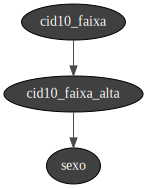

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [31]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn3,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede encontrada pelo treinamento'] = pd.Series(scoreCSV1)

## Rede Bayesiana com conexões obrigatórias

Binary classifier : False


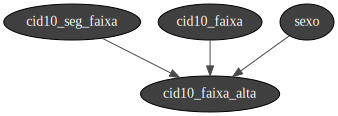

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [32]:
Redebnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn4,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede encontrada pelo treinamento, com conexões obrigatórias'] = pd.Series(scoreCSV1)

## Rede Bayesiana utilizando o Naive Bayes não fixado



Binary classifier : False


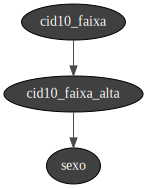

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [33]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn5,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll["Rede encontrada utilizando a estrutura do naive bayes não fixada"] = pd.Series(scoreCSV1)

## Resultados

In [36]:
scoreAll

Naive Bayes sem treinamento  Naive Bayes com treinamento  \
0                     0.166058                     0.705596   

   Naive Bayes Fixado  Rede encontrada pelo treinamento  \
0            0.705596                          0.737835   

   Rede encontrada pelo treinamento, com conexões obrigatórias  \
0                                           0.740876             

   Rede encontrada utilizando a estrutura do naive bayes não fixada  
0                                           0.737835

bayesian_data/X_test.csv: 100%|██████████|


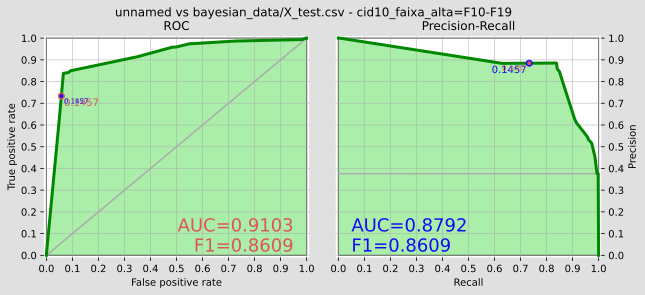

(0.910323218008424, 0.14569274145, 0.8791812869427029, 0.14569274145)

In [37]:
from pyAgrum.lib.bn2roc import showROC_PR
showROC_PR(bn3, "bayesian_data/X_test.csv", 'cid10_faixa_alta', "F10-F19", show_progress=True, show_fig=True)

## Inferências

In [38]:
def NameFromId(graph, id):
    node = graph.variable(id)
    return node.name()

In [39]:
def search(graph, top, bottom):
    topfound = []
    pathfound = []
    flag = False

    # Pega todos os pais do nó dado
    parent = graph.parents(bottom)

    # Caso não possua pais e o nó é encontrado
    if parent == set() and bottom in top:
        return [], [bottom], True

    # Caso não possua pais e o nó não é encontrado
    elif parent == set() and bottom not in top:
        return [], [], False

    # Caso possua pais
    elif parent != set():

        # Caso o nó seja encontrado
        if bottom in top:
            topfound = set([bottom]) | set(topfound)
            flag = True

        # Continua a busca para os pais do nó encontrado
        i = 0
        for node in parent:

            i += 1
            auxpath, auxtop, flag2 = search(graph, top, node)

            # Monta o caminho seguido
            pathfound = set(auxpath) | set(pathfound)

            # Se o nó em especifico fizer parte do caminho de um nó encontrado ele é contabilizado no caminho
            if flag2:
                pathfound = set(pathfound) | set([node])

            topfound = set(auxtop) | set(topfound)

        if flag2:
            flag = True
        return pathfound, topfound, flag
    print('d')
    return pathfound, topfound, flag


In [40]:
# Cria um subgrafo de uma rede passada
def subgraph(graph, top=[], bottom = None):
    if type(graph) == gum.BayesNet:
        g_aux = gum.BayesNet(graph)

        top = list(map(g_aux.idFromName, top))
        bottom = g_aux.idFromName(bottom)
        if bottom == None:
            return 'Colocar último'

        # Encontra os ids validos para subgrafo
        id_nos_validos = search(g_aux, top, bottom)[0]
        id_nos_validos = list(id_nos_validos)
        id_nos_validos.extend([bottom])

        nome_nos_validos = list(map(NameFromId, [g_aux]*len(id_nos_validos), id_nos_validos))
        # print('Nós Válidos', nome_nos_validos)

        # Criacao do subgrafo
        eliminar = set(g_aux.names()).difference(set(nome_nos_validos))
        for node in eliminar:
            g_aux.erase(node)
        return g_aux

    else:
        print('Passar Rede Bayesiana')


In [41]:
# Funcao para retornar a inferencia com grafo reduzido
# Parametros:
#   Grafo: Grafo a ser utilizado na inferencia
#   Evs: Eventos a serem inferenciados. Molde -> {Variavel, ValorAssumido}
#   Nó Investigado: Nó alvo para ser investigado (Último)
def inferencia(graph, evs, no_investigado):
    topos = evs.keys()
    graph = subgraph(graph, topos, no_investigado)
    inf = gnb.getInference(graph, evs = evs)
    return inf

### Rede com conexões obrigatórias

In [42]:
#  Analisando o impacto do sexo no diagnóstico

inf1 = inferencia(bn4, evs = {'sexo': 'M'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'sexo': 'F'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'sexo': 'T'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [43]:
gnb.flow.row(gnb.getInference(bn4, evs = {'sexo': 'F'}))

In [44]:
#  Analisando o impacto da hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn4, evs = {'has': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'has': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'has': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [45]:
# Analisando o impacto de problemas respiratórios no diagnóstico

inf1 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'prob_respiratorios': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [46]:
# Analisando o impacto conjunto de problemas respiratórios e hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'prob_respiratorios': 'SIM', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn4, evs = {'prob_respiratorios': 'SIM', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

In [47]:
# Analisando o impacto do traumatismo no diagnóstico

inf1 = inferencia(bn4, evs = {'traumatismo': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'traumatismo': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'traumatismo': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [48]:
# Analisando o impacto conjunto de traumatismo e problemas respiratórios no diagnóstico

inf1 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'prob_respiratorios': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'prob_respiratorios': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'prob_respiratorios': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'prob_respiratorios': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

In [49]:
# Analisando o impacto conjunto de traumatismo e hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

# Árvore de decisão como guia para a rede bayesiana

In [50]:
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']

labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

In [51]:
df_train, df_test = train_test_split(diagnosticos, train_size = 0.8, random_state=36)

In [52]:
y_train = df_train['cid10_faixa_alta']
X_train = df_train.drop(['cid10_faixa_alta'], axis=1)
y_test = df_test['cid10_faixa_alta']
X_test = df_test.drop(['cid10_faixa_alta'], axis=1)

In [53]:
from sklearn.preprocessing import OneHotEncoder

encX = OneHotEncoder()

X_train_encoded = encX.fit_transform(X_train)
X_test_encoded = encX.transform(X_test)
y_train, y_test = y_train.values, y_test.values
X_train_encoded, X_test_encoded, = X_train_encoded.toarray(), X_test_encoded.toarray()

In [54]:
X_train_encoded

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [55]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(6574, 84)
(1644, 84)


In [56]:
def evaluate(y_pred, y_test):
    acuracia = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted')

    print('Resultados:')
    print(f'    Acuracia: {acuracia}')
    print(f'    F1: {f1}')
    return acuracia, f1

In [57]:
tc = DecisionTreeClassifier(random_state=42)
param_tc = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': range(5, 20, 1)}

gs_tc = GridSearchCV(tc, param_tc, cv=5, scoring='f1_weighted')

best_model = gs_tc.fit(X_train_encoded, y_train)
print(best_model.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}


In [58]:
labels2

['cid10_faixa',
 'cid10_seg_faixa',
 'sexo',
 'faixa_etaria',
 'etnia',
 'qtd_internacoes',
 'traumatismo',
 'prob_respiratorios',
 'avc',
 'convulsao',
 'has',
 'gravidez',
 'diabetes',
 'doenca_infecto']

In [59]:
model = DecisionTreeClassifier(random_state=42, criterion=best_model.best_params_['criterion'], max_depth=best_model.best_params_['max_depth'], splitter=best_model.best_params_['splitter'])
model.fit(X_train_encoded, y_train)
df2 = pd.DataFrame(encX.inverse_transform(X_train_encoded), columns=labels2)

labels3 = []
for i in labels2:
  labels3.extend(df2[i].apply(lambda x: i + '_' + str(x)).unique().tolist())
labels3

dot_data = export_graphviz(model, out_file=None,
                           feature_names=labels3,
                           class_names=np.unique(y_train).tolist(),
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("iris_tree")

'iris_tree.pdf'

In [60]:
y_pred = best_model.predict(X_test_encoded)
acuracia_dt, f1_dt = evaluate(y_pred, y_test)

Resultados:
    Acuracia: 0.7299270072992701
    F1: 0.7414685979309048


In [61]:
template = gum.BayesNet('Plus')
for i in labels:
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
template

(pyAgrum.BayesNet<double>@0x55c6ba4dbbc0) BN{nodes: 15, arcs: 0, domainSize: 10^10.3369, dim: 81, mem: 768o}

In [62]:
# A partir da árvore de decisão é possível pressupor algumas conexões entre variáveis

learner = gum.BNLearner(df_train, template)
learner.addMandatoryArc('cid10_faixa', 'cid10_seg_faixa') # Exemplos
learner.addMandatoryArc('cid10_seg_faixa', 'qtd_internacoes')
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
bn6 = learner.learnBN()

bn6

(pyAgrum.BayesNet<double>@0x55c6b9f5e2a0) BN{nodes: 15, arcs: 20, domainSize: 10^10.3369, dim: 5008, mem: 43Ko 368o}

In [63]:
gimg.export(bn6,"b6.pdf")

Binary classifier : False


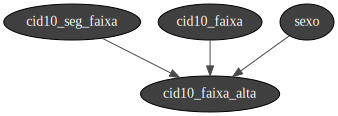

predicted : ['F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F30-F39', 'F10-F19', 'F70-F79', 'F10-F19', 'F60-F69', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F01-F09', 'F20-F29', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F60-F69', 'F30-F39', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F60-F69', 'F30-F39', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19

In [64]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn6,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.tolist()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll["Rede encontrada utilizando a estrutura do naive bayes não fixada"] = pd.Series(scoreCSV1)

In [65]:
#  Analisando o impacto do sexo no diagnóstico

inf1 = inferencia(bn6, evs = {'sexo': 'M'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn6, evs = {'sexo': 'F'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn6, evs = {'sexo': 'T'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)